# Regularized Regression

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preliminary Flow

### Load Data

In [3]:
# load data
admit = pd.read_csv('regression_data.csv')
admit.head()

,gre_score,toefl_score,univ_ranking,motiv_letter_strength,recommendation_strength,gpa,research_exp,admit_prob
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


### Split Data

In [4]:
# split train test
from sklearn.model_selection import train_test_split

feature = admit.drop(columns='admit_prob')
target = admit[['admit_prob']]

feature_admit_train, feature_admit_test, target_admit_train, target_admit_test = train_test_split(feature, target, test_size=0.20, random_state=42)

In [5]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_admit_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,gre_score,4.489983
2,toefl_score,3.664298
3,univ_ranking,2.572110
4,motiv_letter_strength,2.785764
5,recommendation_strength,1.977698
6,gpa,4.654540
7,research_exp,1.518065


There are several features with high VIF scores:
1. `gre_score`
2. `gpa`

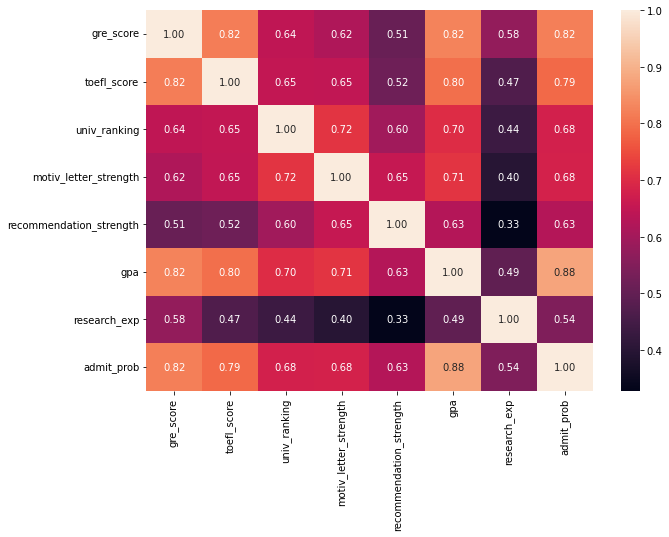

In [6]:
# heatmap correlation
admit_train = pd.concat([feature_admit_train, target_admit_train], axis=1)
corr = admit_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

We choose to retain `gpa`. Therefore, we need to drop:
* `gre_score`
* `toefl_score`

In [7]:
# drop redundant features
feature_admit_train = feature_admit_train.drop(columns=['gre_score','toefl_score'])
feature_admit_test = feature_admit_test.drop(columns=['gre_score','toefl_score'])

### Recheck VIF

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_admit_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,univ_ranking,2.511407
2,motiv_letter_strength,2.748278
3,recommendation_strength,1.965542
4,gpa,2.726281
5,research_exp,1.350514


Good!

## Model Training

### Ridge Regression

In [9]:
from sklearn.linear_model import Ridge

# train the model
X_admit_train = feature_admit_train.to_numpy()
y_admit_train = target_admit_train.to_numpy()
y_admit_train = y_admit_train.reshape(len(y_admit_train),)

# define the model
ridge_reg = Ridge(alpha=0.1, 
                  random_state=42)

ridge_reg.fit(X_admit_train, y_admit_train)

Ridge(alpha=0.1, random_state=42)

In [10]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_admit_train
model = ridge_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,-0.764483
1,univ_ranking,0.007031
2,motiv_letter_strength,0.004406
3,recommendation_strength,0.014806
4,gpa,0.160723
5,research_exp,0.038290


## Lasso

In [11]:
from sklearn.linear_model import Lasso

# define the model
lasso_reg = Lasso(alpha=0.1, 
                  random_state=42)

lasso_reg.fit(X_admit_train, y_admit_train)

Lasso(alpha=0.1, random_state=42)

In [12]:
# retrieve the coefficients
# show as a nice dataframe

data = feature_admit_train
model = lasso_reg

coef_df = pd.DataFrame({
    'feature':['intercept'] + data.columns.tolist(),
    'coefficient':[model.intercept_] + list(model.coef_)
})

coef_df

,feature,coefficient
0,intercept,0.702539
1,univ_ranking,0.006951
2,motiv_letter_strength,0.000000
3,recommendation_strength,0.000000
4,gpa,0.000000
5,research_exp,0.000000


# Workflow with choosing the best lambda

## Split data: train-validation-test

In [13]:
# split train test
from sklearn.model_selection import train_test_split

feature = admit.drop(columns='admit_prob')
target = admit[['admit_prob']]

feature_admit_pretrain, feature_admit_test, target_admit_pretrain, target_admit_test = train_test_split(feature, target, test_size=0.20, random_state=42)

feature_admit_train, feature_admit_validation, target_admit_train, target_admit_validation = train_test_split(feature_admit_pretrain, target_admit_pretrain, test_size=0.20, random_state=42)

## Drop Multicollinear Features

In [14]:
feature_admit_train = feature_admit_train.drop(columns=['gre_score','toefl_score'])
feature_admit_validation = feature_admit_validation.drop(columns=['gre_score','toefl_score'])
feature_admit_test = feature_admit_test.drop(columns=['gre_score','toefl_score'])

## Train Multiple Models
with different alpha (lambda)

In [15]:
from sklearn.linear_model import Ridge

# train the model
X_admit_train = feature_admit_train.to_numpy()
y_admit_train = target_admit_train.to_numpy()
y_admit_train = y_admit_train.reshape(len(y_admit_train),)

# define the model
ridge_reg_pointzeroone = Ridge(alpha=0.01, random_state=42)
ridge_reg_pointone = Ridge(alpha=0.1, random_state=42)
ridge_reg_one = Ridge(alpha=1, random_state=42)
ridge_reg_ten = Ridge(alpha=10, random_state=42)

# fit the model (training)
ridge_reg_pointzeroone.fit(X_admit_train, y_admit_train)
ridge_reg_pointone.fit(X_admit_train, y_admit_train)
ridge_reg_one.fit(X_admit_train, y_admit_train)
ridge_reg_ten.fit(X_admit_train, y_admit_train)

Ridge(alpha=10, random_state=42)

## Find the best model (alpha)
Based on validation set

In [16]:
from sklearn.metrics import mean_squared_error

X_admit_validation = feature_admit_validation.to_numpy()
y_admit_validation = target_admit_validation.to_numpy()
y_admit_validation = y_admit_validation.reshape(len(y_admit_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [ridge_reg_pointzeroone,
          ridge_reg_pointone,
          ridge_reg_one,
          ridge_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_admit_validation)
    rmse = np.sqrt(mean_squared_error(y_admit_validation,y_predict_validation))
    print(f'RMSE of Ridge regression model with alpha = {alpha} is {rmse}')

RMSE of Ridge regression model with alpha = 0.01 is 0.057324682661497074
RMSE of Ridge regression model with alpha = 0.1 is 0.05734237964771407
RMSE of Ridge regression model with alpha = 1.0 is 0.057528698222295366
RMSE of Ridge regression model with alpha = 10 is 0.05983184011212869


## Model Evaluation

In [17]:
ridge_best = ridge_reg_pointzeroone

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_admit_train.columns.tolist(),
    'coefficient':[ridge_best.intercept_] + list(ridge_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,-0.741404
1,univ_ranking,0.005556
2,motiv_letter_strength,0.009497
3,recommendation_strength,0.015778
4,gpa,0.155693
5,research_exp,0.042721


### Diagnostic Study
Not mandatory

In [18]:
from sklearn.metrics import r2_score

y_predict_train = ridge_best.predict(X_admit_train)

print('R-squared for training data is {}'.format(r2_score(y_admit_train, y_predict_train)))

R-squared for training data is 0.7983604440801396


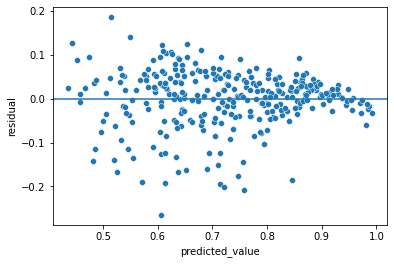

In [19]:
# calculate residuals
residual = y_admit_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

### Training Error

In [20]:
# prepare prediction result on train data
y_predict_train = ridge_best.predict(X_admit_train)

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_admit_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_admit_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_admit_train, y_predict_train)))

RMSE for training data is 0.06452404616839902
MAE for training data is 0.04696727414428013
MAPE for training data is 0.0761569819236105


### Testing Error

In [22]:
# prepare prediction result on test data
X_admit_test = feature_admit_test.to_numpy()
y_predict_test = ridge_best.predict(X_admit_test)

# ground truth target
y_admit_test = target_admit_test.to_numpy()
y_admit_test = y_admit_test.reshape(len(y_admit_test),)

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_admit_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_admit_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_admit_test, y_predict_test)))

RMSE for testing data is 0.05897949876358454
MAE for testing data is 0.039665519822843456
MAPE for testing data is 0.0646079497445827


In [95]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_error(y_admit_test, y_predict_test)
mean_absolute_percentage_error(y_admit_test, y_predict_test)

0.0646079497445827

# Lasso!
Left as casual homework

# Predicting Traffic Volume Using Lasso

In [61]:
# load data
traffic = pd.read_csv('/content/drive/MyDrive/Dibimbing/data/traffic_volume.csv')
traffic.head()

,temp,clouds_all,hour,is_weekend,traffic_volume
0,288.28,40,9,0,5545
1,289.36,75,10,0,4516
2,289.58,90,11,0,4767
3,290.13,90,12,0,5026
4,291.14,75,13,0,4918


In [62]:
# split train test
from sklearn.model_selection import train_test_split

feature = traffic.drop(columns='traffic_volume')
target = traffic[['traffic_volume']]

feature_traffic_pretrain, feature_traffic_test, target_traffic_pretrain, target_traffic_test = train_test_split(feature, target, test_size=0.20, random_state=42)

feature_traffic_train, feature_traffic_validation, target_traffic_train, target_traffic_validation = train_test_split(feature_traffic_pretrain, target_traffic_pretrain, test_size=0.20, random_state=42)

In [63]:
# calulcate vif scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(feature_traffic_train)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,feature,vif_score
1,temp,1.050419
2,clouds_all,1.037852
3,hour,1.013055
4,is_weekend,1.000949


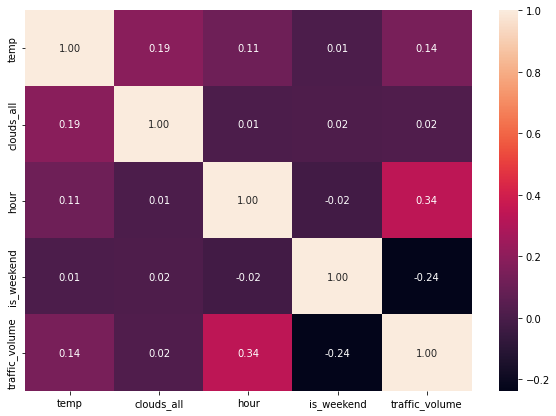

In [64]:
# heatmap correlation
traffic_train = pd.concat([feature_traffic_train, target_traffic_train], axis=1)
corr = traffic_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

NO need to drop!

In [65]:
from sklearn.linear_model import Lasso

# train the model
X_traffic_train = feature_traffic_train.to_numpy()
y_traffic_train = target_traffic_train.to_numpy()
y_traffic_train = y_traffic_train.reshape(len(y_traffic_train),)

# define the model
lasso_reg_pointzeroone = Lasso(alpha=0.01, random_state=42)
lasso_reg_pointone = Lasso(alpha=0.1, random_state=42)
lasso_reg_one = Lasso(alpha=1, random_state=42)
lasso_reg_ten = Lasso(alpha=10, random_state=42)

# fit the model (training)
lasso_reg_pointzeroone.fit(X_traffic_train, y_traffic_train)
lasso_reg_pointone.fit(X_traffic_train, y_traffic_train)
lasso_reg_one.fit(X_traffic_train, y_traffic_train)
lasso_reg_ten.fit(X_traffic_train, y_traffic_train)

Lasso(alpha=10, random_state=42)

## Find the best model (alpha)
Based on validation set

In [66]:
from sklearn.metrics import mean_squared_error

X_traffic_validation = feature_traffic_validation.to_numpy()
y_traffic_validation = target_traffic_validation.to_numpy()
y_traffic_validation = y_traffic_validation.reshape(len(y_traffic_validation),)

alphas = [0.01, 0.1, 1., 10]
models = [lasso_reg_pointzeroone,
          lasso_reg_pointone,
          lasso_reg_one,
          lasso_reg_ten]

for model, alpha in zip(models, alphas):
    y_predict_validation = model.predict(X_traffic_validation)
    rmse = np.sqrt(mean_squared_error(y_traffic_validation,y_predict_validation))
    print(f'RMSE of Lasso regression model with alpha = {alpha} is {rmse}')

RMSE of Lasso regression model with alpha = 0.01 is 1758.7557046935883
RMSE of Lasso regression model with alpha = 0.1 is 1758.74786966802
RMSE of Lasso regression model with alpha = 1.0 is 1758.669967940547
RMSE of Lasso regression model with alpha = 10 is 1758.010309344725


## Model Evaluation

In [67]:
lasso_best = lasso_reg_ten

coef_df = pd.DataFrame({
    'feature':['intercept'] + feature_traffic_train.columns.tolist(),
    'coefficient':[lasso_best.intercept_] + list(lasso_best.coef_)
})

coef_df

,feature,coefficient
0,intercept,-4365.600873
1,temp,25.016157
2,clouds_all,0.003057
3,hour,93.107203
4,is_weekend,-957.562828


### Diagnostic Study

In [68]:
from sklearn.metrics import r2_score

y_predict_train = lasso_best.predict(X_traffic_train)

print('R-squared for training data is {}'.format(r2_score(y_traffic_train, y_predict_train)))

R-squared for training data is 0.17925637278788864


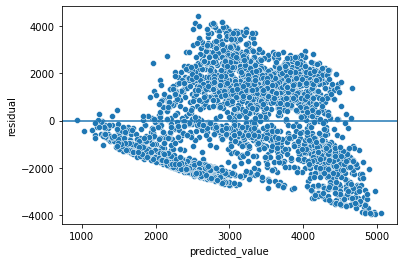

In [69]:
# calculate residuals
residual = y_traffic_train - y_predict_train

# prepare dataframe
# 1 predictor --> predictor VS residual
df_resid = pd.DataFrame({
    'predicted_value': y_predict_train,
    'residual': residual
})

# residual plot
sns.scatterplot(data=df_resid, x="predicted_value", y="residual")
plt.axhline(0)
plt.show()

### Training Error

In [70]:
# prepare prediction result on training data
y_predict_train = lasso_best.predict(X_traffic_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_traffic_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_traffic_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_traffic_train, y_predict_train)))

RMSE for training data is 1805.286522023116
MAE for training data is 1591.5207121977246
MAPE for training data is 1.3231338056293216


### Testing Error

In [71]:
# prepare prediction result on test data
X_traffic_test = feature_traffic_test.to_numpy()
y_predict_test = lasso_best.predict(X_traffic_test)

# ground truth target
y_traffic_test = target_traffic_test.to_numpy()
y_traffic_test = y_traffic_test.reshape(len(y_traffic_test),)

In [72]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for testing data is {}'.format(np.sqrt(mean_squared_error(y_traffic_test, y_predict_test))))
print('MAE for testing data is {}'.format(mean_absolute_error(y_traffic_test, y_predict_test)))
print('MAPE for testing data is {}'.format(mean_absolute_percentage_error(y_traffic_test, y_predict_test)))

RMSE for testing data is 1814.257100567723
MAE for testing data is 1612.5211560998812
MAPE for testing data is 1.459673857916026
